In [1]:
import warnings
warnings.filterwarnings("ignore") 

import os
import numpy as np
import pandas as pd

from importlib import reload
import pickle
from functools import reduce

import feature_selection
import transform_data

from pytorch_forecasting.data.timeseries import TimeSeriesDataSet

In [2]:
data_pickle = "../data/data_pickle/"
data_out = "../data/data_TFT/"
data_TS = "../data/data_TS/"

In [3]:
data_files = {}

print("Data files:")
for i, filename in enumerate(os.listdir(data_pickle)):
    with open(os.path.join(data_pickle, filename), 'rb') as file:
        data =  pickle.load(file)
        data_files[filename[:-4]] = data
    print(f"{i+1}: {filename}")

Data files:
1: calendar_info.pkl
2: imbalance_prices_q.pkl
3: photovoltaic_q.pkl
4: total_load_q.pkl
5: wind_q.pkl


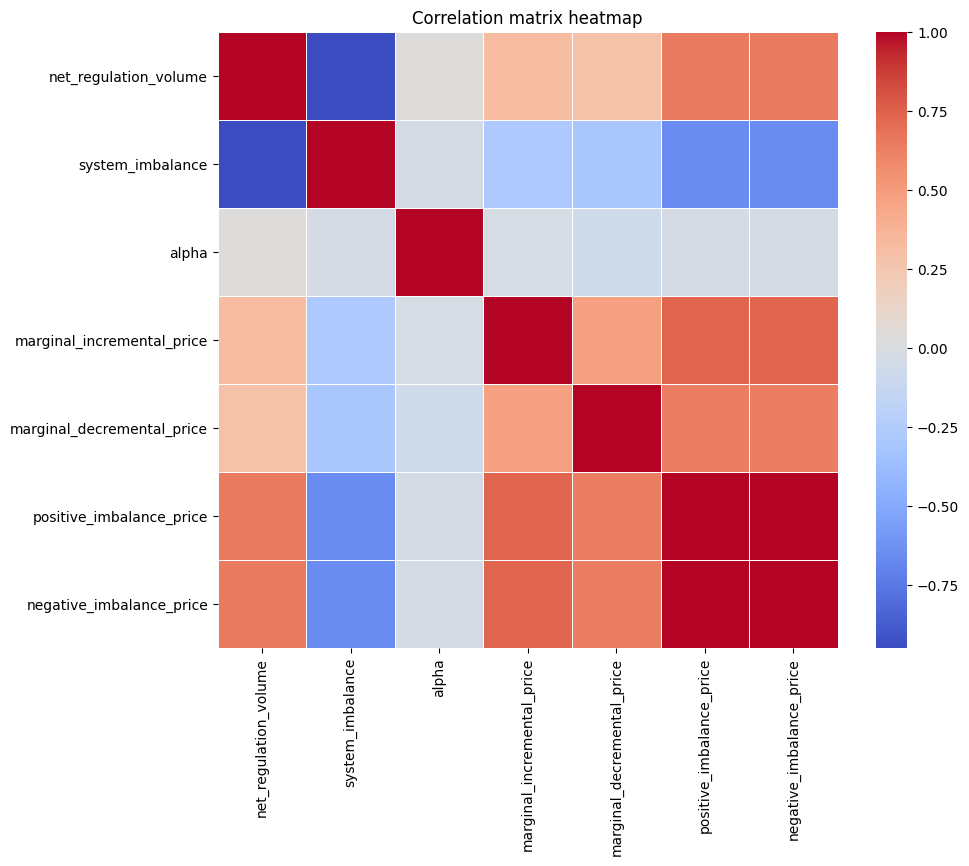

In [4]:
data_final = data_files["imbalance_prices_q"]

correlation_matrix = data_final.corr()
feature_selection.plot_corrmat(correlation_matrix)

In [5]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='left'), list(data_files.values()))
merged_df = merged_df.drop("datetime", axis=1)

column_to_move = 'datetime_utc'
merged_df = merged_df[[column_to_move] + [col for col in merged_df.columns if col != column_to_move]]

## reverse the dataset to go chronologically with the index
merged_df = merged_df.iloc[::-1].reset_index(drop=True)
merged_df.head()

,datetime_utc,holiday,not_working,net_regulation_volume,system_imbalance,alpha,marginal_incremental_price,marginal_decremental_price,positive_imbalance_price,negative_imbalance_price,...,total_load,most_recent_forecast_load,most_recent_p10_load,most_recent_p90_load,day-ahead_6pm_forecast_load,measured_&_upscaled_wind,most_recent_forecast_wind,most_recent_p10_wind,most_recent_p90_wind,day-ahead_6pm_forecast_wind
0,2021-12-31 23:00:00,1,1,-238.403,324.503,2.50,185.55,-58.16,-60.66,-60.66,...,8300.28,8483.90,7906.48,9061.32,8661.15,2332.81,2454.02,1690.30,2722.54,2479.58
1,2021-12-31 23:15:00,1,1,-274.681,503.440,72.97,154.00,-56.71,-129.68,-129.68,...,8209.80,8368.22,7798.68,8937.77,8543.83,2480.50,2426.00,1654.24,2701.51,2450.36
2,2021-12-31 23:30:00,1,1,-274.846,248.898,48.62,181.74,-88.24,-136.86,-136.86,...,8020.42,8230.95,7670.75,8791.15,8404.20,2231.79,2388.36,1622.93,2675.04,2416.58
3,2021-12-31 23:45:00,1,1,-232.667,251.465,8.84,154.00,19.31,10.47,10.47,...,7913.85,8077.70,7527.93,8627.47,8247.88,2203.88,2355.36,1584.19,2648.15,2387.76
4,2022-01-01 00:00:00,1,1,-50.896,62.864,0.00,154.00,16.65,16.65,16.65,...,7842.55,7706.56,7350.33,8062.79,8399.25,2033.59,2343.28,1637.11,2608.64,2361.21


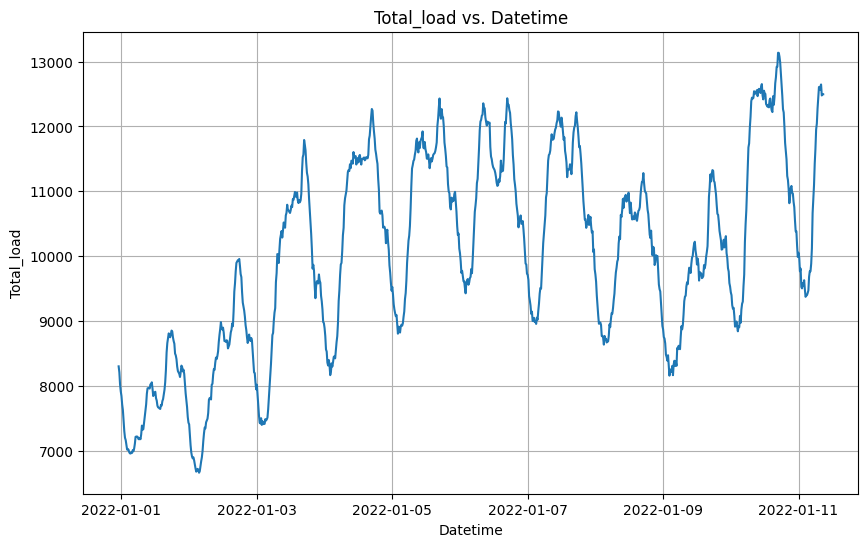

In [6]:
import matplotlib.pyplot as plt

df = merged_df.iloc[0:1000]

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df.datetime_utc, df['total_load'])

plt.xlabel('Datetime')
plt.ylabel('Total_load')
plt.title('Total_load vs. Datetime')
plt.grid(True)
plt.show()

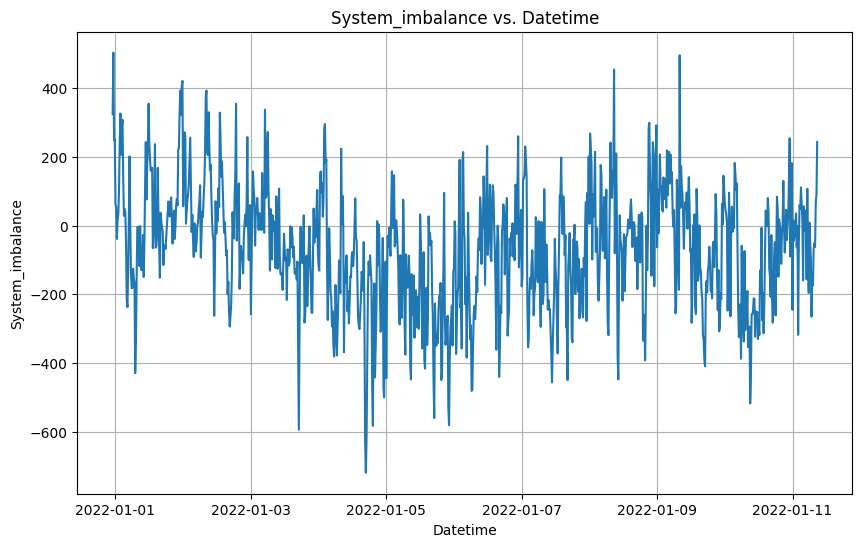

In [7]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df.datetime_utc, df['system_imbalance'])

plt.xlabel('Datetime')
plt.ylabel('System_imbalance')
plt.title('System_imbalance vs. Datetime')
plt.grid(True)
plt.show()

In [21]:
reload(transform_data)
reload(feature_selection)

<module 'feature_selection' from 'd:\\Uni_FJFI\\NMS3\\DP\\project_I\\System-Imbalance-Forecasting\\data_processing\\feature_selection.py'>

In [22]:
feature_selection.additional_features(merged_df, "datetime_utc")
print("Nrows of the merged dataset with additional features:", merged_df.shape[0])

ts_df = merged_df.copy()
ts_df = ts_df[ts_df["year"] != "2021"]
ts_df = transform_data.convert_category_to_float(ts_df, ['year', 'not_working', 'holiday'])
with open(os.path.join(data_TS, 'merged_data.pkl'), 'wb') as f:
    pickle.dump(ts_df, f,  protocol=4)

ts_df.head()

Nrows of the merged dataset with additional features: 58364


,datetime_utc,holiday,not_working,net_regulation_volume,system_imbalance,alpha,marginal_incremental_price,marginal_decremental_price,positive_imbalance_price,negative_imbalance_price,...,month_cos,day_sin,day_cos,hour_sin,hour_cos,quarter_hour_sin,quarter_hour_cos,weekday,weekday_sin,weekday_cos
4,2022-01-01 00:00:00,1.0,1.0,-50.896,62.864,0.0,154.00,16.65,16.65,16.65,...,0.866025,0.017213,0.999852,0.000000,1.000000,0.000000e+00,1.000000e+00,5,0.781831,0.62349
5,2022-01-01 00:15:00,1.0,1.0,-39.365,54.215,0.0,154.00,16.65,16.65,16.65,...,0.866025,0.017213,0.999852,0.000000,1.000000,1.000000e+00,6.123234e-17,5,0.781831,0.62349
6,2022-01-01 00:30:00,1.0,1.0,54.935,-38.410,0.0,154.00,16.65,154.00,154.00,...,0.866025,0.017213,0.999852,0.000000,1.000000,1.224647e-16,-1.000000e+00,5,0.781831,0.62349
7,2022-01-01 00:45:00,1.0,1.0,7.202,15.970,0.0,154.00,16.65,16.65,16.65,...,0.866025,0.017213,0.999852,0.000000,1.000000,-1.000000e+00,-1.836970e-16,5,0.781831,0.62349
8,2022-01-01 01:00:00,1.0,1.0,-17.846,33.283,0.0,162.68,48.19,48.19,48.19,...,0.866025,0.017213,0.999852,0.258819,0.965926,0.000000e+00,1.000000e+00,5,0.781831,0.62349


In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58364 entries, 0 to 58363
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datetime_utc                  58364 non-null  datetime64[ns]
 1   holiday                       58364 non-null  category      
 2   not_working                   58364 non-null  category      
 3   net_regulation_volume         58364 non-null  float64       
 4   system_imbalance              58364 non-null  float64       
 5   alpha                         58364 non-null  float64       
 6   marginal_incremental_price    58364 non-null  float64       
 7   marginal_decremental_price    58364 non-null  float64       
 8   positive_imbalance_price      58364 non-null  float64       
 9   negative_imbalance_price      58364 non-null  float64       
 10  measured_&_upscaled_solar     58364 non-null  float64       
 11  most_recent_forecast_solar  

In [25]:
numerical_known = [
    "day-ahead_6pm_forecast_wind", "most_recent_forecast_wind", "day-ahead_6pm_forecast_load", "most_recent_forecast_load", "day-ahead_6pm_forecast_solar", "most_recent_forecast_solar",
]

numerical_unknown = [
    "system_imbalance", "measured_&_upscaled_solar", "total_load", "measured_&_upscaled_wind",
]

categorical_know = [
    "not_working", "holiday", "month", "day", "weekday", "hour", "quarter_hour"
]

In [31]:
train_split = pd.Timestamp('2023-03-01 00:00:00')
test_split = pd.Timestamp('2023-06-01 00:00:00')

data_train = merged_df[lambda x: x.datetime_utc <= train_split].copy()
data_train = data_train.fillna(data_train.median())

data_val = merged_df[lambda x: (train_split < x.datetime_utc) & (x.datetime_utc <= test_split)].copy()
data_val = data_val.fillna(data_train.median(numeric_only=True))

data_test = merged_df[lambda x: x.datetime_utc > test_split].copy()
data_test = data_test.fillna(data_train.median())

print("Training set / All data:", round(data_train.shape[0]/ merged_df.shape[0], 3))
print("Validation set / All data:", round(data_val.shape[0]/ merged_df.shape[0], 3))
print("Test set / All data:", round(data_test.shape[0]/ merged_df.shape[0], 3))

Training set / All data: 0.698
Validation set / All data: 0.151
Test set / All data: 0.151


In [36]:
max_prediction_length = 8
max_encoder_length = 32

In [37]:
training = TimeSeriesDataSet(
    data_train,
    time_idx="index",
    target="system_imbalance",
    group_ids=["group"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=categorical_know,
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=numerical_known,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=numerical_unknown,
    #lags = {"system_imbalance": [i for i in range(4*24-2*4, 4*24+6*4)] + [i for i in range(7*4*24-2*4, 7*4*24+6*4)]},
    lags = {"system_imbalance": [4*24-2*4, 7*4*24-2*4]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    predict_mode=False,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data_val, predict=False, stop_randomization=True)
test = TimeSeriesDataSet.from_dataset(training, data_test, predict=False, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)

In [38]:
to_pickle = [merged_df, training, train_dataloader, validation, val_dataloader, test, test_dataloader]

with open(os.path.join(data_out, 'input_data.pkl'), 'wb') as f:
    pickle.dump(to_pickle, f,  protocol=4)